In [1]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. 데이터 준비

In [3]:
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs',
                                        split=['train', 'test'],
                                        shuffle_files=True,
                                        with_info=True)

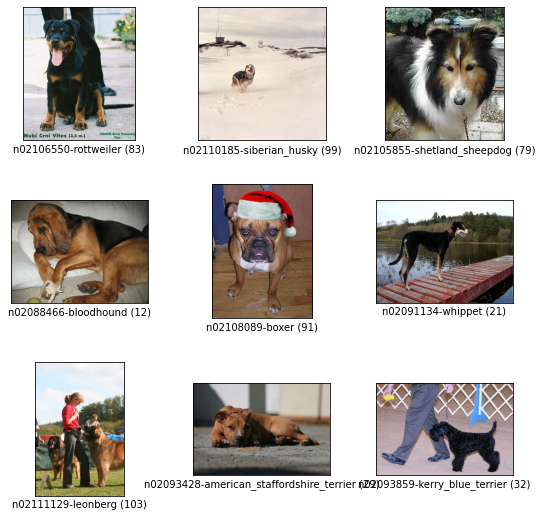

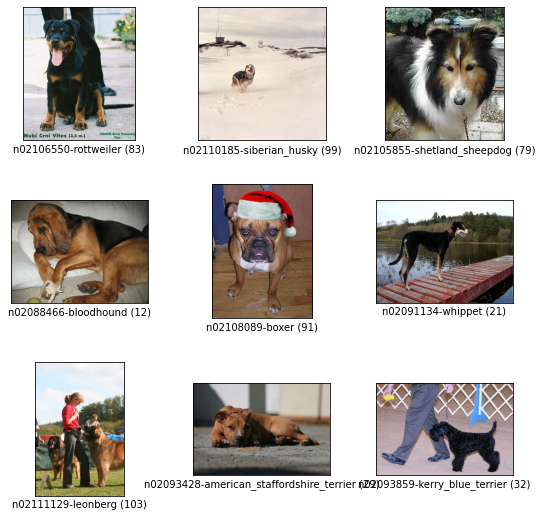

In [4]:
# 각 이미지의 클래스와 그 인덱스 확인.
tfds.show_examples(ds_train, ds_info)

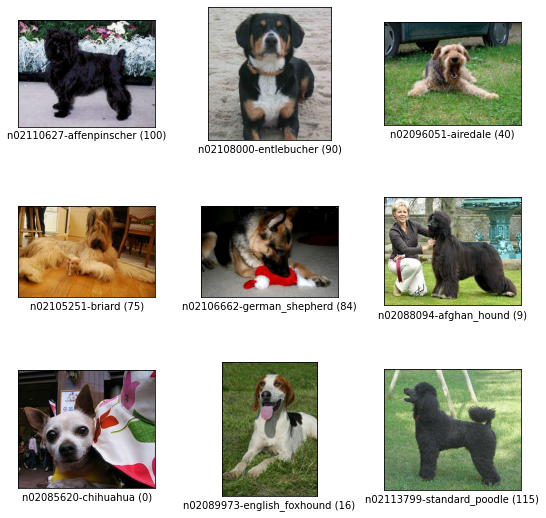

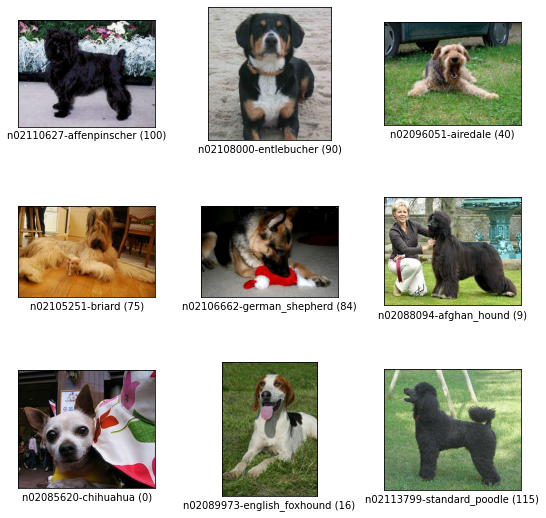

In [5]:
# 평가용 데이터셋도 확인.
tfds.show_examples(ds_test, ds_info)

In [6]:
# 물체의 위치정보
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

# 2. 전처리

In [7]:
def normalize_and_resize_img(input):
    # Normalizes images: 'uint8' -> 'float32'
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img,
               num_parallel_calls=2)
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다.
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [9]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

67


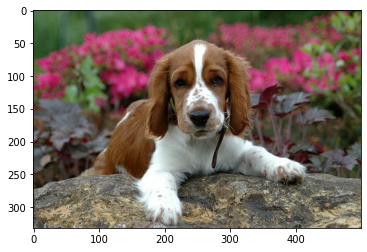

In [10]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

# 3. 모델링 및 학습

In [11]:
# ResNet50 + GAP + DenseLayer   CAM Model
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(include_top=False,  # Imagenet 분류기 fully connected layer 제거
                                                 weights='imagenet',
                                                 input_shape=(224, 224, 3),
                                                 pooling='avg')  # GAP를 적용, avg means that global average pooling...

x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [12]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [13]:
# 학습된 모델 불러오기
#import os
#cam_model_path = os.getenv('HOME') + '/aiffel/class_activation_map/cam_model.h5'
#cam_model = tf.keras.models.load_model(cam_model_path)

In [14]:
cam_model.compile(loss='sparse_categorical_crossentropy',
                 optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics=['accuracy'])

In [15]:
history_cam_model = cam_model.fit(ds_train_norm,
                                 steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
                                 validation_steps=int(ds_info.splits['test'].num_examples/16),
                                 epochs=15,
                                 validation_data=ds_val_norm,
                                 verbose=1,
                                 use_multiprocessing=True)

Epoch 1/15
750/750 [==============================] - 161s 204ms/step - loss: 2.2533 - accuracy: 0.4363 - val_loss: 3.4185 - val_accuracy: 0.1996
Epoch 2/15
750/750 [==============================] - 152s 202ms/step - loss: 0.6341 - accuracy: 0.8328 - val_loss: 1.2281 - val_accuracy: 0.6348
Epoch 3/15
750/750 [==============================] - 152s 202ms/step - loss: 0.1717 - accuracy: 0.9747 - val_loss: 1.1234 - val_accuracy: 0.6764
Epoch 4/15
750/750 [==============================] - 152s 203ms/step - loss: 0.0564 - accuracy: 0.9975 - val_loss: 0.9865 - val_accuracy: 0.7212
Epoch 5/15
750/750 [==============================] - 152s 203ms/step - loss: 0.0298 - accuracy: 0.9987 - val_loss: 0.9998 - val_accuracy: 0.7197
Epoch 6/15
750/750 [==============================] - 152s 202ms/step - loss: 0.0208 - accuracy: 0.9992 - val_loss: 1.0408 - val_accuracy: 0.7193
Epoch 7/15
750/750 [==============================] - 152s 202ms/step - loss: 0.0153 - accuracy: 0.9994 - val_loss: 0.9885 -

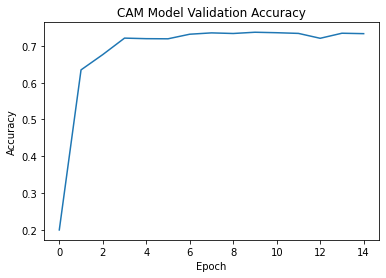

In [16]:
plt.plot(history_cam_model.history['val_accuracy'])
plt.title('CAM Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

* 크게 튀지않고 안정적이게 수렴하고 있습니다.

In [17]:
import os

cam_model_path = os.getenv('HOME') + '/aiffel/class_activation_map/cam_model5.h5'
cam_model.save(cam_model_path)
print('saved')

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


saved


# CAM 구현하기

In [18]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]
    
    cam_image /= np.max(cam_image)  # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height))  # 원래 이미지의 크기로 resize 합니다.
    
    return cam_image

11


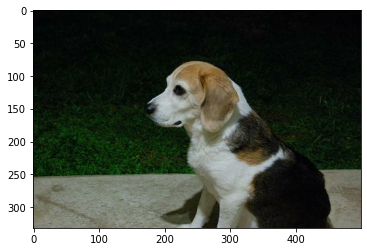

In [67]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

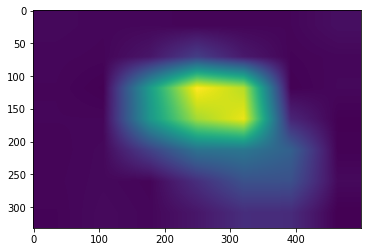

In [68]:
# CAM 이미지 출력
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [69]:
# CAM 이미지 + 원본 이미지
def visualize_cam_on_image(image, cam_image, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    return merged_image

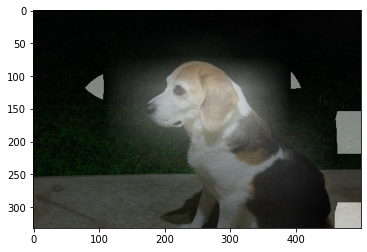

In [70]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image * 255] * 3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

* 원본 이미지와 CAM 이미지의 영역을 합친 결과, 강아지의 얼굴위주로 특징을 잡은것 같습니다.

# Grad-CAM 구현하기

In [71]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        
        loss = pred[:, class_idx]  # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0]  # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0]  # 예측값에 따른 Layer의 gradient를 얻습니다.
        
    weights = np.mean(grad_val, axis=(0, 1))  # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
    
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    
    return grad_cam_image

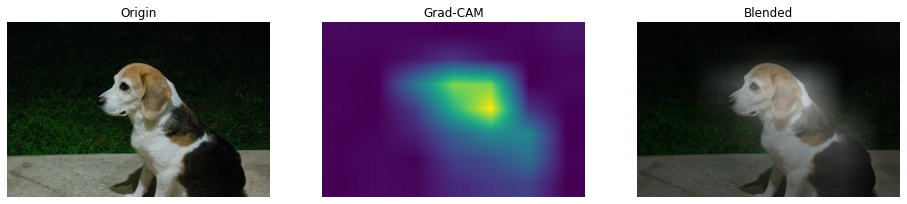

In [72]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)

origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image * 255] * 3, axis=-1).astype(np.uint8)
grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)

plt.figure(figsize=(16, 20))
plt.subplot(131)
plt.imshow(item['image'])
plt.title("Origin")
plt.axis("off")

plt.subplot(132)
plt.imshow(grad_cam_image)
plt.title("Grad-CAM")
plt.axis("off")

plt.subplot(133)
plt.imshow(grad_blended_image)
plt.title("Blended")
plt.axis("off")

plt.show()

* Grad-CAM은 얼굴 중에서도 귀쪽을 주요 특징으로 잡은 것 같습니다.

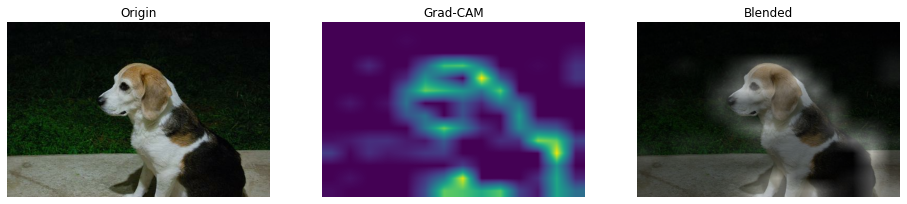

In [73]:
grad_cam_image1 = generate_grad_cam(cam_model, 'conv4_block3_out', item)

grad_cam_image_3channel1 = np.stack([grad_cam_image1 * 255] * 3, axis=-1).astype(np.uint8)
grad_blended_image1 = visualize_cam_on_image(grad_cam_image_3channel1, origin_image)

plt.figure(figsize=(16, 20))
plt.subplot(131)
plt.imshow(item['image'])
plt.title("Origin")
plt.axis("off")

plt.subplot(132)
plt.imshow(grad_cam_image1)
plt.title("Grad-CAM")
plt.axis("off")

plt.subplot(133)
plt.imshow(grad_blended_image1)
plt.title("Blended")
plt.axis("off")

plt.show()

* 마지막 전 블럭으로 만든 이미지는 강아지 가장자리 위주로 잡혀있네요.

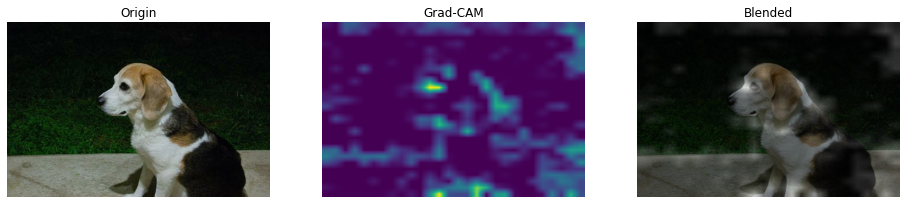

In [74]:
grad_cam_image2 = generate_grad_cam(cam_model, 'conv3_block3_out', item)

grad_cam_image_3channel2 = np.stack([grad_cam_image2 * 255] * 3, axis=-1).astype(np.uint8)
grad_blended_image2 = visualize_cam_on_image(grad_cam_image_3channel2, origin_image)

plt.figure(figsize=(16, 20))
plt.subplot(131)
plt.imshow(item['image'])
plt.title("Origin")
plt.axis("off")

plt.subplot(132)
plt.imshow(grad_cam_image2)
plt.title("Grad-CAM")
plt.axis("off")

plt.subplot(133)
plt.imshow(grad_blended_image2)
plt.title("Blended")
plt.axis("off")

plt.show()

* 한 단계 더 이전으로 갔더니 특징이 거의 잡혀있지 않습니다.

## 바운딩 박스 구하기

In [75]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image * 255).astype(np.uint8)
    
    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [76]:
# 원본 이미지 bbox
def minmax_to_rect(bbox, image):
    x_min = int(bbox[1] * image.shape[1])
    x_max = int(bbox[3] * image.shape[1])
    y_min = int(bbox[0] * image.shape[0])
    y_max = int(bbox[2] * image.shape[0])
    
    # rect의 좌표순서는 사각형의 좌측하단부터 반시계 방향입니다.
    rect = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]])
    return rect

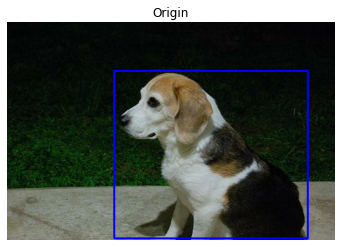

In [77]:
# Origin bbox
rect = minmax_to_rect(item['objects']['bbox'][0], item['image'])

image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0, 0, 255), 2)
plt.imshow(image)
plt.title("Origin")
plt.axis("off")
plt.show()

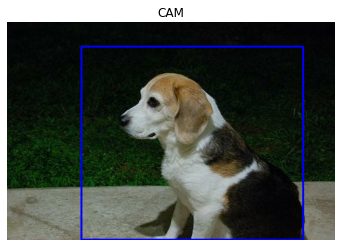

In [78]:
# CAM bbox
cam_rect = get_bbox(cam_image)

image = copy.deepcopy(item['image'])
image_cam = cv2.drawContours(image, [cam_rect], 0, (0, 0, 255), 2)
plt.imshow(image_cam)
plt.title("CAM")
plt.axis("off")
plt.show()

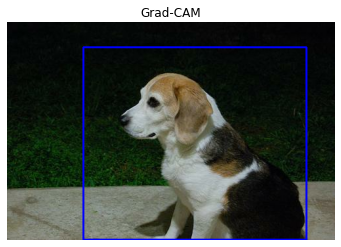

In [79]:
# Grad-CAM bbox
grad_rect = get_bbox(grad_cam_image)

image = copy.deepcopy(item['image'])
image_grad = cv2.drawContours(image, [grad_rect], 0, (0, 0, 255), 2)
plt.imshow(image_grad)
plt.title("Grad-CAM")
plt.axis("off")
plt.show()

## IoU 구하기

<img src="https://d3s0tskafalll9.cloudfront.net/media/images/GC-3-P-3.max-800x600.jpg" width="300" height="300"/>

In [80]:
def rect_to_minmax(rect, image):
    bbox = [rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
           rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
           rect[:,1].max()/float(image.shape[0]),  #bounding box의 y_max
           rect[:,0].max()/float(image.shape[1])]  #bounding box의 x_max
    return bbox

In [81]:
def get_iou(gt_bbox, pred_bbox):
    y_min = max(gt_bbox[0], pred_bbox[0])
    x_min = max(gt_bbox[1], pred_bbox[1])
    y_max = min(gt_bbox[2], pred_bbox[2])
    x_max = min(gt_bbox[3], pred_bbox[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    boxBArea = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

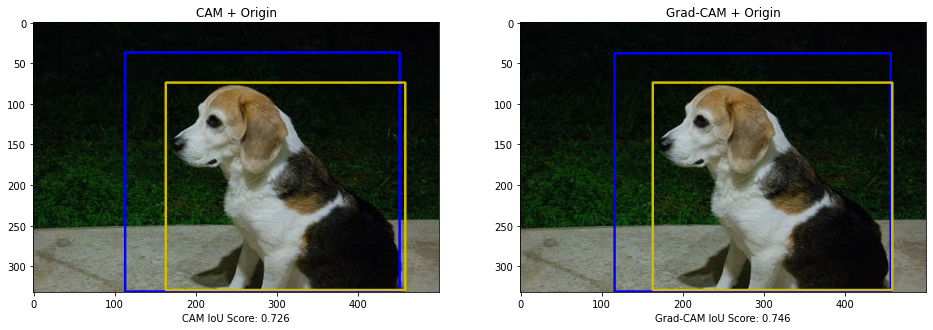

In [82]:
cam_pred_bbox = rect_to_minmax(cam_rect, item['image'])
grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
cam_iou = get_iou(cam_pred_bbox, item['objects']['bbox'][0])
grad_iou = get_iou(grad_pred_bbox, item['objects']['bbox'][0])

plt.figure(figsize=(16,20))
plt.subplot(121)
image_cam = cv2.drawContours(image_cam, [rect], 0, (210, 190, 0), 2)
plt.imshow(image_cam)
plt.title("CAM + Origin")
plt.xlabel(f'CAM IoU Score: {cam_iou:.3f}')

plt.subplot(122)
image_grad = cv2.drawContours(image_grad, [rect], 0, (210, 190, 0), 2)
plt.imshow(image_grad)
plt.title("Grad-CAM + Origin")
plt.xlabel(f'Grad-CAM IoU Score: {grad_iou:.3f}')

plt.show()

* CAM은 조금 벗어나 있는데, Grad-CAM은 원본의 바운딩 박스안에 들어가 있어서 IoU Score가 더 높은 것 같습니다.

# 회고

* 본 과정에서는 ResNet + GAP + Dense Layer로 만들어진 모델을 활용하여 CAM과 Grad-CAM의 Object Localization 성능을 IoU Score로 계산 시 어느정도 차이가 있는지 확인해 봅니다.
* 본 결과에서는 0.02 점 정도 근소한 차이로 Grad-CAM가 더 좋지만, 이미지에 따라 CAM이 더 좋은 경우도 더러 있습니다.
* Grad-CAM의 단계별 블럭에서 추출한 활성화 맵들로 이미지의 특징을 찾아내는 순서를 눈으로 확인하여 object localization을 이해함에 있어 많은 도움이 되었습니다.